<a href="https://colab.research.google.com/github/ihtesham0332/Cate-vs-Doge-classification-Model/blob/main/Cats_Vs_Dogs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!makdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

/bin/bash: line 1: makdir: command not found
cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 99% 778M/788M [00:05<00:00, 161MB/s]
100% 788M/788M [00:06<00:00, 137MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/microsoft-catsvsdogs-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/microsoft-catsvsdogs-dataset.zip' mode='r'>>

In [47]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import os
import shutil
import random

# Define the source directory and the destination directories
source_dir = '/content/PetImages'
train_dir = '/content/train'
test_dir = '/content/test'

# Create the destination directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through the subdirectories (Cat and Dog) in the source directory
for class_name in ['Cat', 'Dog']:
    class_dir = os.path.join(source_dir, class_name)

    # Get a list of all image files in the class directory
    image_files = os.listdir(class_dir)

    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Calculate the split index for train and test (e.g., 80% train, 20% test)
    split_index = int(0.8 * len(image_files))

    # Copy images to the train and test directories
    for i, image_file in enumerate(image_files):
        source_path = os.path.join(class_dir, image_file)
        if i < split_index:
            destination_path = os.path.join(train_dir, class_name, image_file)
        else:
            destination_path = os.path.join(test_dir, class_name, image_file)

        # Create the destination directory if it doesn't exist
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        # Copy the image file
        shutil.copy(source_path, destination_path)

print("Train and test data folders created successfully.")

# Define a preprocessing function to ensure correct number of channels and normalization
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

# Function to filter out corrupted images
def is_valid_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        return True
    except:
        return False

# Remove corrupted images
def clean_dataset(dataset_dir):
    for class_name in ['Cat', 'Dog']:
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)
        for image_file in image_files:
            file_path = os.path.join(class_dir, image_file)
            if not is_valid_image(file_path):
                os.remove(file_path)
                print(f"Removed corrupted image: {file_path}")

clean_dataset(train_dir)
clean_dataset(test_dir)

# Load the datasets
train_data_set = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256)
)

test_data_set = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256)
)

train_data_set = train_data_set.map(process)
test_data_set = test_data_set.map(process)

# Define the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    MaxPool2D(pool_size=(2, 2), padding='valid', strides=2),
    Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPool2D(pool_size=(2, 2), padding='valid', strides=2),
    Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPool2D(pool_size=(2, 2), padding='valid', strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data_set, epochs=10, validation_data=test_data_set)

print("Model training complete.")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data_set)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Train and test data folders created successfully.
Removed corrupted image: /content/train/Cat/Thumbs.db
Removed corrupted image: /content/train/Cat/666.jpg
Removed corrupted image: /content/train/Cat/4351.jpg
Removed corrupted image: /content/train/Cat/10404.jpg
Removed corrupted image: /content/train/Dog/11233.jpg
Removed corrupted image: /content/train/Dog/9500.jpg
Removed corrupted image: /content/train/Dog/11702.jpg
Removed corrupted image: /content/train/Dog/11912.jpg
Removed corrupted image: /content/train/Dog/Thumbs.db
Removed corrupted image: /content/train/Dog/2317.jpg
Removed corrupted image: /content/train/Dog/2494.jpg
Removed corrupted image: /content/test/Cat/666.jpg
Removed corrupted image: /content/test/Cat/10404.jpg
Removed corrupted image: /content/test/Dog/11233.jpg
Removed corrupted image: /content/test/Dog/9500.jpg
Removed corrupted image: /content/test/Dog/Thumbs.db
Found 24797 files belonging to 2 classes.
Found 12204 files belonging to 2 classes.
Model: "sequenti

In [49]:
save_path = '/content/model.h5'
model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


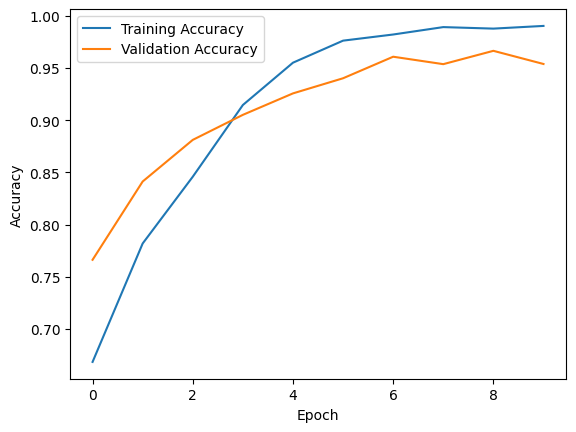

In [48]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

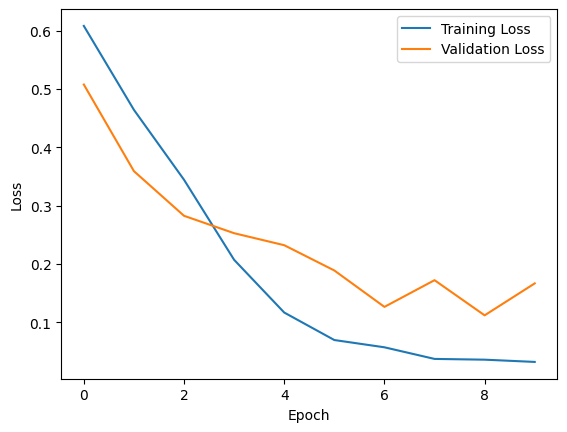

In [55]:
#training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

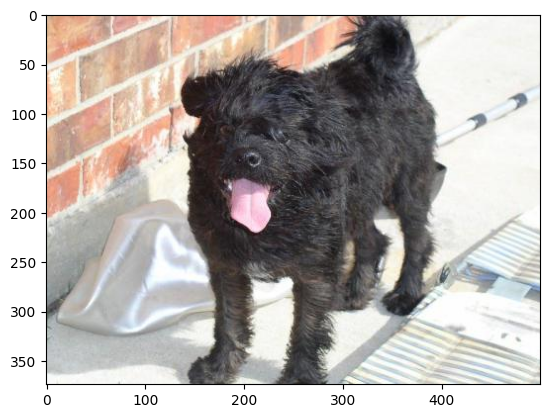

In [80]:
#check new image category
import cv2
import matplotlib.pyplot as plt
test_image = cv2.imread('/content/38.jpg')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()


In [81]:
test_image.shape

(374, 500, 3)

In [84]:
resiz_image = cv2.resize(test_image, (256, 256))

In [85]:
test_input=resiz_image.reshape(1,256,256,3)


In [86]:
model.predict(test_input)

1/1 [==============================] - 0s 28ms/step


array([[2.7317643e-15]], dtype=float32)

1/1 [==============================] - 0s 92ms/step
Predicted class: Dog, Prediction score: [0.9999682]


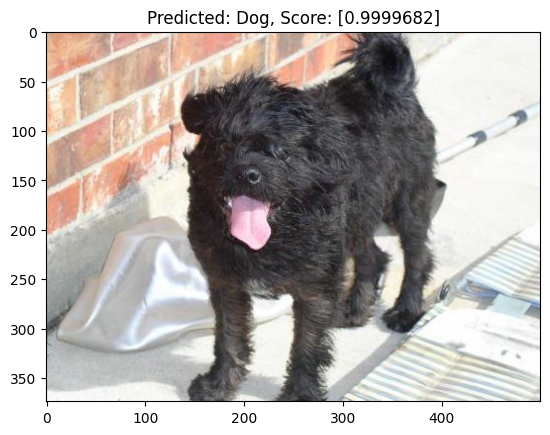

In [88]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = keras.models.load_model('/content/model.h5')

# Function to preprocess the image
def preprocess_image(image_path, img_size=(256, 256)):
    # Read the image
    img = cv2.imread(image_path)
    # Resize the image
    img = cv2.resize(img, img_size)
    # Normalize the image
    img = img / 255.0
    # Expand dimensions to match the expected input shape
    img = np.expand_dims(img, axis=0)
    return img

# Function to make a prediction
def predict_image(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Make a prediction
    prediction = model.predict(img)
    # Get the predicted class
    predicted_class = 'Dog' if prediction[0] > 0.5 else 'Cat'
    return predicted_class, prediction[0]

# Path to a single image
image_path = '/content/38.jpg'

# Make a prediction
predicted_class, prediction_score = predict_image(image_path)

print(f"Predicted class: {predicted_class}, Prediction score: {prediction_score}")


# Display the image
img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_class}, Score: {prediction_score}")
plt.show()
